# Run Dowjons directly on the quantized data

KeyboardInterrupt: 

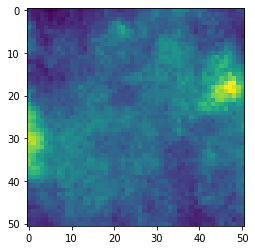

In [9]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import os
import sys
from networks.gan import Generator, Generator256, Generator512
import scipy.io as sio
import torch
from utils import *
from quantization_model_log import *
from tqdm import trange
from qmc_utils import init_z, load_generator, load_data
from IPython.display import clear_output, display

S, C, T, S_true, C_true, T_true = load_data()
generator = load_generator()

# ae_path = '/scratch/sagar/Projects/matlab/deep-spectrum-cartography/deep_prior/trained_models/slf_network.model'
# ae_network = torch.load(ae_path)
# ae_network.eval()
# generator = ae_network.decoder

# parameters
z_dimension = 256
maxIter = 500
R,I,J = S.shape
K = 64
Z_init = torch.zeros((R, z_dimension), dtype=torch.float32)
Z = torch.zeros((R, z_dimension), dtype=torch.float32)
lambda_c = 100
lambda_s = 100
f = 0.1
std_probit = 0.008
loss_model = 'probit'  # one of 'sigmoid', 'probit', and 'determ'

nmse_list = []

# Mask
Om = torch.ones((64,1,51,51))*f
Om = torch.bernoulli(Om)
Wx = Om

T = T.permute(2,0,1)
T_true = T_true.permute(2,0,1)
S = S.permute(2,0,1)
S_true = S_true.permute(2,0,1)
C = C.permute(1,0)
C_true = C_true.permute(1,0)

T_old = T.clone()
S_old = S.clone()

# bin_boundaries = torch.tensor(QUANTIZATION_BOUNDARIES_4_BINS)
# offset = LOG_OFFSET_4

bin_boundaries = torch.tensor(QUANTIZATION_BOUNDARIES_7_ADJUSTED)
offset = LOG_OFFSET_7_ADJUSTED

# warm start
C_init = C.clone()
S_init = S.clone()
S_init = S_init.unsqueeze(dim=1)

# zero start
S_init = torch.zeros(S_init.shape)
C_init = torch.zeros(C_init.shape)

T = T.unsqueeze(dim=1)
T_init = get_tensor(S_init, C_init)
var_list = [SD_16_BINS_UNIFORM*2]
var_list = [3]

Z_init = torch.randn((R, 256))

nmses = np.zeros((len(var_list), maxIter))
costs = np.zeros((len(var_list), maxIter))

for var_id in range(len(var_list)):
    var = var_list[var_id]
    std_probit = var
    
    # here the quantized ordinal values are converted to the actual data 
    Y = quantize(T_true, std_probit, bin_boundaries)
    Y = Y.unsqueeze(dim=1)
    Obs = get_quantized_obs_from_ordinal(Y, bin_boundaries, std_probit)
    
    S = S_init.clone()
    C = C_init.clone()
    Z = Z_init.clone()

    Z = Z.detach().clone()
    C.requires_grad = True
    Z.requires_grad = True

    optimizerC = torch.optim.Adam([C], lr=0.005)
    optimizerZ = torch.optim.Adam([Z], lr=0.01)

    with torch.no_grad():
        S = generator(Z)

    print("Initial nmse: {}".format(NMSE(get_tensor(generator(Z), C), T_true)))
    for i in range(maxIter):

        # C optimization
        S = generator(Z)
        Sc = S.detach().clone()
        optimizerC.zero_grad()

        T_hat = get_tensor(Sc, C)
        T_hat = T_hat.unsqueeze(dim=1)
        T_hat = torch.log(T_hat+offset)
        
        cost = torch.norm(Wx*(T_hat-Obs))**2 + lambda_c*torch.norm(C, 'fro') + lambda_s*torch.norm(Z, 'fro')
        
        cost.backward()
        optimizerC.step()
        with torch.no_grad():
            C[C<0] = 0
       
        true_loss = NMSE(get_tensor(S,C), T_true)
        nmses[var_id][i] = true_loss
        costs[var_id][i] = cost

        # S optimization
        optimizerZ.zero_grad()
        S = generator(Z)
        
        T_hat = get_tensor(S, C)
        T_hat = T_hat.unsqueeze(dim=1)
        T_hat = torch.log(T_hat+offset)
        cost = torch.norm(Wx*(T_hat-Obs))**2 + lambda_c*torch.norm(C, 'fro') + lambda_s*torch.norm(Z, 'fro')

        cost.backward()
        optimizerZ.step()

        true_loss = NMSE(get_tensor(S,C), T_true)
        nmses[var_id][i] = true_loss
        costs[var_id][i] = cost
        
        clear_output(wait=True)    
        display(plt.gcf())
        print('iter {}, cost: {}, nmse: {}'.format(i, cost, true_loss))
        plt.imshow(T_hat[17,...].squeeze().detach().numpy())
    print('ended {}'.format(std_probit))
    nmse_list.append(true_loss)

In [3]:
 lambda_c*torch.norm(C, 'fro') 

tensor(0.0004, grad_fn=<MulBackward0>)

Text(0.5, 0.98, 'Reconstruction using Euclidean norm criterion, shadow variance = 3, decorrelation distance = 90, 2 bits per scalar, 10% sampling')

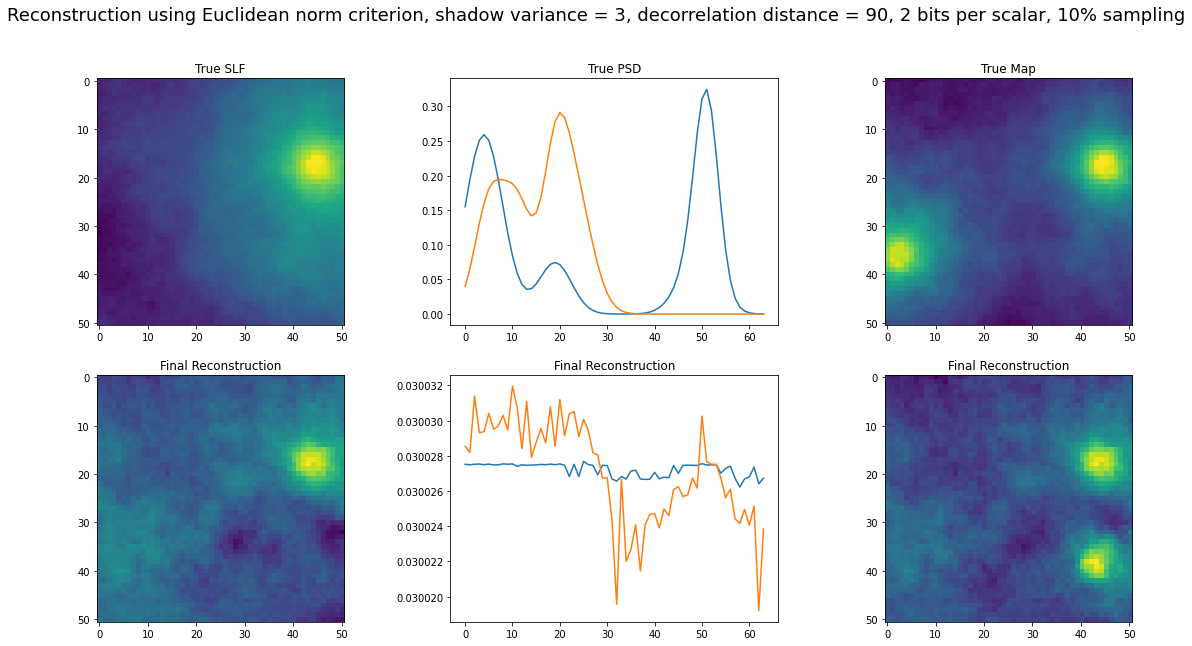

In [16]:
fig, ax = plt.subplots(2,3, figsize=(20,10))

ax[0,0].imshow(torch.log(S_true[0,...]).squeeze().detach().numpy())
ax[0,0].set_title('True SLF')
ax[1,0].imshow(torch.log(S[1,...]).squeeze().detach().numpy())
ax[1,0].set_title('Final Reconstruction')

ax[0,1].plot(C_true[0,:].detach().numpy())
ax[0,1].set_title('True PSD')
ax[1,1].plot(C[0,:].detach().numpy())
ax[1,1].set_title('Final Reconstruction')


ax[0,1].plot(C_true[1,:].detach().numpy())
ax[0,1].set_title('True PSD')
ax[1,1].plot(C[1,:].detach().numpy())
ax[1,1].set_title('Final Reconstruction')

k = 5
T_hat = get_tensor(S, C)

ax[0,2].imshow(torch.log(T_true[k,...]).squeeze().detach().numpy())
ax[0,2].set_title('True Map')
ax[1,2].imshow(torch.log(T_hat[k,...]).squeeze().detach().numpy())
ax[1,2].set_title('Final Reconstruction')

fig.suptitle('Reconstruction using Euclidean norm criterion, shadow variance = 3, decorrelation distance = 90, 2 bits per scalar, 10% sampling', fontsize=18)


In [17]:
fig.savefig('data/2norm_small_shadowing_image.pdf')

Text(0.5, 0.98, 'Reconstruction using Euclidean norm criterion, shadow variance = 3, decorrelation distance = 90, 2 bits per scalar, 10% sampling')

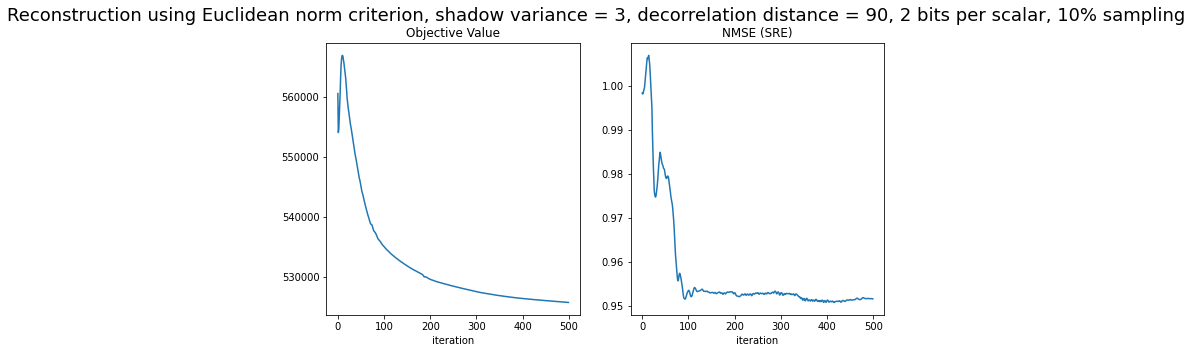

In [18]:
fig, ax = plt.subplots(len(var_list), 2, figsize=(10,5))
ax[0].plot(costs[0][:500])
# ax[0].set_ylabel('sigma = '+str(var_list[i]))
ax[1].plot(nmses[0][:500])
ax[1].set_title('NMSE (SRE)')
ax[0].set_title('Objective Value')
ax[0].set_xlabel('iteration')
ax[1].set_xlabel('iteration')

fig.suptitle('Reconstruction using Euclidean norm criterion, shadow variance = 3, decorrelation distance = 90, 2 bits per scalar, 10% sampling', fontsize=18)


In [19]:
fig.savefig('data/2norm_small_shadowing_plot.pdf')

In [ ]:
costs[0]

# Plot for QMC

Text(0.5, 1.0, 'LNFAC reconstruction')

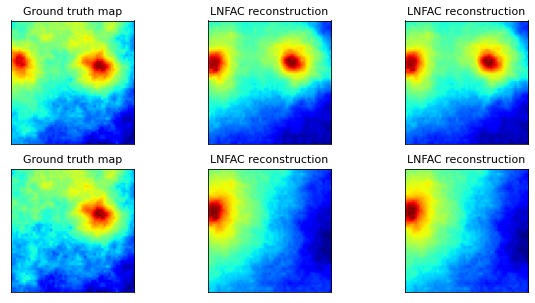

In [24]:
fig, ax = plt.subplots(2,3, figsize=(10, 5))
cmap = plt.cm.get_cmap("jet")
k = 17
fontsize = 11

folder_name = '5_percent_backup_compare'
T_qmc = torch.load('data/' + folder_name + '/T_hat.pt')
S_qmc = torch.load('data/' + folder_name + '/S.pt')

ax[0,0].imshow(torch.log(T_true[k,...]).squeeze().detach().numpy(), cmap=cmap)
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,0].set_title('Ground truth map', fontsize=fontsize)
# ax[0].set_xlabel('(a)', fontsize=fontsize)


ax[0,1].imshow((T_hat[k,...]).squeeze().detach().numpy(), cmap=cmap)
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_title('LNFAC reconstruction', fontsize=fontsize)
# ax[0,2].set_xlabel('(b)', fontsize=fontsize)


ax[0,2].imshow((T_qmc[k,...]).squeeze().detach().numpy(), cmap=cmap)
ax[0,2].set_xticks([])
ax[0,2].set_yticks([])
ax[0,2].set_title('LNFAC reconstruction', fontsize=fontsize)
# ax[0,2].set_xlabel('(b)', fontsize=fontsize)

ax[1,0].imshow(torch.log(S_true[0,...]).squeeze().detach().numpy(), cmap=cmap)
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
ax[1,0].set_title('Ground truth map', fontsize=fontsize)
# ax[0].set_xlabel('(a)', fontsize=fontsize)


ax[1,1].imshow(torch.log(S[0,...]).squeeze().detach().numpy(), cmap=cmap)
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
ax[1,1].set_title('LNFAC reconstruction', fontsize=fontsize)
# ax[0,2].set_xlabel('(b)', fontsize=fontsize)


ax[1,2].imshow(torch.log(S_qmc[0,...]).squeeze().detach().numpy(), cmap=cmap)
ax[1,2].set_xticks([])
ax[1,2].set_yticks([])
ax[1,2].set_title('LNFAC reconstruction', fontsize=fontsize)
# ax[0,2].set_xlabel('(b)', fontsize=fontsize)
# plt.tight_layout()

In [16]:
T_hat

tensor([[[[ -9.7661,  -9.7213,  -9.6984,  ..., -11.7252, -11.5586, -11.5779],
          [ -9.6126,  -9.5988,  -9.6364,  ..., -11.5667, -11.5066, -11.6166],
          [ -9.7178,  -9.5733,  -9.1469,  ..., -11.5485, -11.7214, -11.8101],
          ...,
          [-11.2593, -11.2853, -11.2411,  ..., -12.7492, -12.5838, -12.7464],
          [-11.5349, -11.3305, -11.3692,  ..., -12.7291, -12.5912, -12.8833],
          [-11.4033, -11.3434, -11.4575,  ..., -12.8144, -12.9026, -13.1060]]],


        [[[ -9.7661,  -9.7213,  -9.6984,  ..., -11.7252, -11.5586, -11.5779],
          [ -9.6126,  -9.5988,  -9.6364,  ..., -11.5667, -11.5066, -11.6165],
          [ -9.7178,  -9.5733,  -9.1469,  ..., -11.5485, -11.7214, -11.8101],
          ...,
          [-11.2593, -11.2853, -11.2411,  ..., -12.7492, -12.5838, -12.7464],
          [-11.5349, -11.3305, -11.3693,  ..., -12.7291, -12.5912, -12.8833],
          [-11.4033, -11.3434, -11.4575,  ..., -12.8144, -12.9026, -13.1060]]],


        [[[ -9.7661,  -9.7